In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch_geometric.data import DataLoader

import os
import numpy as np
import pandas as pd

from ogb.nodeproppred import PygNodePropPredDataset
from ogb.linkproppred import PygLinkPropPredDataset

from ogb.graphproppred import PygGraphPropPredDataset

cwd = os.getcwd()
os.chdir('/home/sandbox/workspace/causal_attn')

from models import *
from utils import *
from train import *
from run import instantiate_model
from evaluations import *

os.chdir(cwd)

## Planetoid

In [95]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
device = 0

task = 'npp'
eval_metric = 'acc'
base_suffix = 'interv.dataloader.ep400.early_stop.lr_small.ratio'
  
for dataset_name in ['Cora','CiteSeer','PubMed'][0:2]:
  print('=====   {}   ====='.format(dataset_name))
  
  for suffix in [base_suffix,base_suffix + '.labelprop.new2',base_suffix + '.shuffle.rand.unif']:
    print(suffix)
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    dim_in,dim_out,edge_dim,pred_criterion = get_dataset_params(dataset_name,train_loader,10)

    eval_metric = 'acc'
    params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                   'heads': [1,3,5],
                   'nl': [1,2],
                   'hd': [100,200],
                   'lc': [1.0,5.0],
                   'ni': [5]}

    save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)

    results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
    results_path = os.path.join(results_dir,'{}.{}.eval_ablation.tsv'.format(dataset_name,suffix))
    if os.path.exists(results_path + "K"):
      results_df = pd.read_csv(results_path,sep='\t')
    else:
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix=suffix,task=task)
      results_df.to_csv(results_path,sep='\t')

=====   Cora   =====
interv.dataloader.ep400.early_stop.lr_small.ratio
interv.dataloader.ep400.early_stop.lr_small.ratio.labelprop.new2
interv.dataloader.ep400.early_stop.lr_small.ratio.shuffle.rand.unif
=====   CiteSeer   =====
interv.dataloader.ep400.early_stop.lr_small.ratio
interv.dataloader.ep400.early_stop.lr_small.ratio.labelprop.new2
interv.dataloader.ep400.early_stop.lr_small.ratio.shuffle.rand.unif


In [96]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
device = 0

for dataset_name in ['Cora','CiteSeer','PubMed'][0:2]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  
  base_suffix = 'interv.dataloader.ep400.early_stop.lr_small.ratio'
  
  for suffix in [base_suffix,base_suffix + '.labelprop.new2',base_suffix + '.shuffle.rand.unif']:
    print(suffix)
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    dim_in,dim_out,edge_dim,pred_criterion = get_dataset_params(dataset_name,train_loader,10)

    eval_metric = 'acc'
    params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                   'heads': [1,3,5],
                   'nl': [1,2],
                   'hd': [100,200],
                   'lc': [1.0,5.0],
                   'ni': [5]}

    save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)

    results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
    results_path = os.path.join(results_dir,'{}.{}.eval_loss_ablation.tsv'.format(dataset_name,suffix))
    if os.path.exists(results_path + "K"):
      results_df = pd.read_csv(results_path,sep='\t')
    else:
      results_df = evaluate_models_loss(dataset_name,valid_loader,test_loader,pred_criterion,save_dir,params_dict,
                                        device=device,suffix=suffix,task=task)
      results_df.to_csv(results_path,sep='\t')

=====   Cora   =====
interv.dataloader.ep400.early_stop.lr_small.ratio
interv.dataloader.ep400.early_stop.lr_small.ratio.labelprop.new2
interv.dataloader.ep400.early_stop.lr_small.ratio.shuffle.rand.unif
=====   CiteSeer   =====
interv.dataloader.ep400.early_stop.lr_small.ratio
interv.dataloader.ep400.early_stop.lr_small.ratio.labelprop.new2
interv.dataloader.ep400.early_stop.lr_small.ratio.shuffle.rand.unif


In [99]:
from scipy.stats import ttest_ind

lc_thresh = 1

eval_metric = 'acc'
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep400.early_stop.lr_small.ratio'

for dataset_name in ['Cora','CiteSeer','PubMed'][0:2]:

  df_list = []
  for suffix in [base_suffix,base_suffix + '.labelprop.new2',base_suffix + '.shuffle.rand.unif']:
    
    results_path = os.path.join(results_dir,'{}.{}.eval_ablation.tsv'.format(dataset_name,suffix))
    results_df = pd.read_csv(results_path,sep='\t')
    del results_df['Unnamed: 0']
    results_df = results_df[results_df['set'] == 'test']
    results_df = results_df[results_df['lc'] >= lc_thresh]
    results_df = results_df[results_df['n_layers'] >= 1]
    results_df = results_df[results_df['lc'] < 10]
    df_list.append(results_df)

  print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',wilcoxon(df_list[0][eval_metric],df_list[1][eval_metric],alternative='greater')[1])
  print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',wilcoxon(df_list[0][eval_metric],df_list[2][eval_metric],alternative='greater')[1])
  
#   print('')
  
  # print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',ttest_ind(df_list[0][eval_metric],df_list[1][eval_metric],alternative='greater',equal_var=False)[1])
  # print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',ttest_ind(df_list[0][eval_metric],df_list[2][eval_metric],alternative='greater',equal_var=False)[1])
  
  print('================================')
  
  
  # print('t-test:',ttest_ind(delta_lc_low,delta_lc_high,alternative='less',equal_var=False))


Cora    	 Causal vs. LabelProp (loss): p  =  0.9971408411899273
Cora    	 Causal vs. Random (loss): p  =  0.9949604394322636
CiteSeer    	 Causal vs. LabelProp (loss): p  =  0.9999807689460657
CiteSeer    	 Causal vs. Random (loss): p  =  0.9999994465742454


In [101]:
from scipy.stats import ttest_ind

lc_thresh = 1

eval_metric = 'acc'
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep400.early_stop.lr_small.ratio'

for dataset_name in ['Cora','CiteSeer','PubMed']:

  df_list = []
  for suffix in [base_suffix,base_suffix + '.labelprop.new2',base_suffix + '.shuffle.rand.unif']:
    
    results_path = os.path.join(results_dir,'{}.{}.eval_loss_ablation.tsv'.format(dataset_name,suffix))
    results_df = pd.read_csv(results_path,sep='\t')
    del results_df['Unnamed: 0']
    results_df = results_df[results_df['set'] == 'test']
    results_df = results_df[results_df['lc'] >= lc_thresh]
    # results_df = results_df[results_df['n_layers'] == 1]
    # results_df = results_df[results_df['lc'] < 10]
    df_list.append(results_df)

  print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',wilcoxon(df_list[0]['loss'],df_list[1]['loss'],alternative='less')[1])
  print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',wilcoxon(df_list[0]['loss'],df_list[2]['loss'],alternative='less')[1])
  
#   print('')
  
  # print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',ttest_ind(df_list[0]['loss'],df_list[1]['loss'],alternative='less',equal_var=False)[1])
  # print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',ttest_ind(df_list[0]['loss'],df_list[2]['loss'],alternative='less',equal_var=False)[1])
  
  print('================================')
  
  
  # print('t-test:',ttest_ind(delta_lc_low,delta_lc_high,alternative='less',equal_var=False))


Cora    	 Causal vs. LabelProp (loss): p  =  0.9994326032605249
Cora    	 Causal vs. Random (loss): p  =  0.9998676497429916
CiteSeer    	 Causal vs. LabelProp (loss): p  =  0.9999962350375192
CiteSeer    	 Causal vs. Random (loss): p  =  0.9999999997386687
PubMed    	 Causal vs. LabelProp (loss): p  =  0.7016325918749721
PubMed    	 Causal vs. Random (loss): p  =  0.5463621107389938


In [3]:
from scipy.stats import ttest_ind

lc_thresh = 1

eval_metric = 'acc'
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep400.early_stop.ratio'

for dataset_name in ['Cora','CiteSeer','PubMed']:

  df_list = []
  for suffix in [base_suffix,base_suffix + '.labelprop.new2',base_suffix + '.shuffle.rand.set']:
    
    results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
    results_df = pd.read_csv(results_path,sep='\t')
    del results_df['Unnamed: 0']
    results_df = results_df[results_df['set'] == 'test']
    results_df = results_df[results_df['lc'] >= lc_thresh]
    # results_df = results_df[results_df['lc'] < 10]
    df_list.append(results_df)

  print(dataset_name,'   \t','Causal vs. LabelProp (acc): p  = ',wilcoxon(df_list[0][eval_metric],df_list[1][eval_metric],alternative='greater')[1])
  print(dataset_name,'   \t','Causal vs. Random (acc): p  = ',wilcoxon(df_list[0][eval_metric],df_list[2][eval_metric],alternative='greater')[1])
  
#   print('')
  
#   print(dataset_name,'   \t','Causal vs. LabelProp (acc): p  = ',ttest_ind(df_list[0][eval_metric],df_list[1][eval_metric],alternative='greater',equal_var=False)[1])
#   print(dataset_name,'   \t','Causal vs. Random (acc): p  = ',ttest_ind(df_list[0][eval_metric],df_list[2][eval_metric],alternative='greater',equal_var=False)[1])
  
  print('================================')
  
  
  # print('t-test:',ttest_ind(delta_lc_low,delta_lc_high,alternative='less',equal_var=False))


In [103]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
device = 0

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep400.early_stop.lr_small.ratio'

for dataset_name in ['Cora','CiteSeer','PubMed']:
  
  print('==========================')
  print(dataset_name)
  df_list = []
  for suffix in [base_suffix,base_suffix + '.labelprop.new2',base_suffix + '.shuffle.rand.unif']:
    
    # print(suffix)
    results_path = os.path.join(results_dir,'{}.{}.eval_loss_ablation.tsv'.format(dataset_name,suffix))
    results_df = pd.read_csv(results_path,sep='\t')

    plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
    for eval_set in ['test']:
      plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
      filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
      filtered_results_df = filtered_results_df[filtered_results_df['n_layers'] >= 1]
      filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] >= 1)]
      # filtered_results_df = filtered_results_df[filtered_results_df['lc'] == 50]
      plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='loss',
                                 alpha_feat='lc',save_path=None,plot=False)
      print(suffix,plot_df.shape[0],'-----',wilcoxon(plot_df['x'],plot_df['y'],alternative='greater')[1]) #,'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

Cora
interv.dataloader.ep400.early_stop.lr_small.ratio 72 ----- 2.0648002758047372e-11
interv.dataloader.ep400.early_stop.lr_small.ratio.labelprop.new2 72 ----- 2.2707166677651346e-12
interv.dataloader.ep400.early_stop.lr_small.ratio.shuffle.rand.unif 72 ----- 6.292590810286406e-13
CiteSeer
interv.dataloader.ep400.early_stop.lr_small.ratio 72 ----- 0.0715079435968813
interv.dataloader.ep400.early_stop.lr_small.ratio.labelprop.new2 72 ----- 0.00013526978048437587
interv.dataloader.ep400.early_stop.lr_small.ratio.shuffle.rand.unif 72 ----- 2.6677860345839075e-05
PubMed
interv.dataloader.ep400.early_stop.lr_small.ratio 108 ----- 0.05020013444901066
interv.dataloader.ep400.early_stop.lr_small.ratio.labelprop.new2 108 ----- 0.0016276769822259941
interv.dataloader.ep400.early_stop.lr_small.ratio.shuffle.rand.unif 108 ----- 0.003972324469752811


## ogbn-arxiv

## Wikipedia

In [50]:
lc_thresh = 1

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep100.early_stop.ratio'

for dataset_name in ['chameleon','squirrel']:
  
  df_list = []
  for suffix in [base_suffix,base_suffix + '.labelprop',base_suffix + '.shuffle.rand.unif']:
    
    results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
    results_df = pd.read_csv(results_path,sep='\t')
    del results_df['Unnamed: 0']
    results_df = results_df[results_df['set'] == 'test']
    results_df = results_df[results_df['lc'] >= lc_thresh]
    results_df = results_df[results_df['lc'] < 10]
    results_df = results_df[results_df['n_layers'] >= 1]
    columns2keep = [n for n in results_df.columns if n not in ['model','split_no','loss']]
    # results_df = results_df.groupby(columns2keep).mean().reset_index()
    df_list.append(results_df)

  print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',wilcoxon(df_list[0]['loss'],df_list[1]['loss'],alternative='less')[1])
  print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',wilcoxon(df_list[0]['loss'],df_list[2]['loss'],alternative='less')[1])

  print('================================')

chameleon    	 Causal vs. LabelProp (loss): p  =  0.8595681652716363
chameleon    	 Causal vs. Random (loss): p  =  0.9999123441655716
squirrel    	 Causal vs. LabelProp (loss): p  =  0.043241330405150796
squirrel    	 Causal vs. Random (loss): p  =  0.9999963194474188


In [ ]:
lc_thresh = 1

eval_metric = 'acc'
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep100.early_stop.ratio'

for dataset_name in ['chameleon','squirrel']:
  
  df_list = []
  for suffix in [base_suffix,base_suffix + '.labelprop',base_suffix + '.shuffle']:
    
    results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
    results_df = pd.read_csv(results_path,sep='\t')
    del results_df['Unnamed: 0']
    results_df = results_df[results_df['set'] == 'test']
    results_df = results_df[results_df['lc'] >= lc_thresh]
    # results_df = results_df[results_df['lc'] < 10]
    columns2keep = [n for n in results_df.columns if n not in ['model','split_no','loss']]
    # results_df = results_df.groupby(columns2keep).mean().reset_index()
    df_list.append(results_df)

  print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',wilcoxon(df_list[0]['loss'],df_list[1]['loss'],alternative='less')[1])
  print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',wilcoxon(df_list[0]['loss'],df_list[2]['loss'],alternative='less')[1])

  print('================================')

In [24]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
device = 0

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep100.early_stop.ratio'

for dataset_name in ['chameleon','squirrel'][0:1]:
  
  print('==========================')
  print(dataset_name)
  df_list = []
  for suffix in [base_suffix,base_suffix + '.labelprop.new2',base_suffix + '.shuffle.rand.unif'][0:1]:
    
    # print(suffix)
    results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
    results_df = pd.read_csv(results_path,sep='\t')
    
    results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
    results_df['gat_layer'] = [n.split('.')[0] for n in results_df['model']]
    columns2keep = [n for n in results_df.columns if n not in ['split_no','loss']]
    results_df = results_df.groupby(columns2keep).mean().reset_index()
    
    plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
    for eval_set in ['test']:
      plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
      filtered_results_df = results_df[results_df['dim_hidden'] >= 10]
      filtered_results_df = filtered_results_df[filtered_results_df['n_layers'] >= 1]
      filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] >= 0.01)]
      filtered_results_df = filtered_results_df[filtered_results_df['lc'] < 10]
      plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='loss',
                                 alpha_feat='lc',save_path=None,plot=False)
      print(suffix,plot_df.shape[0],'-----',wilcoxon(plot_df['x'],plot_df['y'],alternative='greater')[1]) #,'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

chameleon
interv.dataloader.ep100.early_stop.ratio 144 ----- 6.954926509124122e-22


## WebKB

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['cornell','wisconsin'][0:1]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=0

  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2][0:1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/webkb/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path + "K"):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix='{}.{}'.format(suffix,split_no),task=task)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','acc']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  results_df['gat_layer'] = [n.split('.')[0] for n in results_df['model']]
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['n_layers'] >= 1]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] <= 5)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=None)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=None)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Label Agreement

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = True

for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep400.early_stop.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    results_df.to_csv(results_path,sep='\t')

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'label_agreement.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 1)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 100]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=plot_path)
    print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
weight_by_degree = True

for dataset_name in ['ogbn-arxiv']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [50,100,200][1:2],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=0)
    results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    # results_df['split_no'] = split_no
    results_df.to_csv(results_path,sep='\t')

  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  # results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'label_agreement.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] >= 0)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=plot_path)
    print('Pos rate:',filtered_results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
weight_by_degree = True

for dataset_name in ['chameleon','squirrel']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=1

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2][0:1],
                 'hd': [10,25,100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                    device=device,suffix='{}.{}'.format(suffix,split_no),task=task,weight_by_degree=weight_by_degree)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    # results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'label_agreement.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] <= 25]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] >= 0)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=plot_path)
    print('Pos rate:',filtered_results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
weight_by_degree = True

for dataset_name in ['cornell','wisconsin','texas'][0:2]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=1

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25,50,100],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/webkb/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path + "K"):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                    device=device,suffix='{}.{}'.format(suffix,split_no),task=task,weight_by_degree=weight_by_degree)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 50]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=None)
    print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Label Agreement vs. Loss

In [ ]:
from scipy.stats import spearmanr,pearsonr

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

for dataset_name in ['chameleon','squirrel']: #,'cornell','wisconsin']:
  
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
  eval_df = pd.read_csv(results_path,sep='\t')
  if 'Unnamed: 0' in eval_df.columns:
    del eval_df['Unnamed: 0'] 
  eval_df['model'] = ['.'.join(n.split('.')[:-1]) for n in eval_df['model']]
  columns2keep = [n for n in eval_df.columns if n not in ['split_no','loss']]
  eval_df = eval_df.groupby(columns2keep).mean().reset_index()
  eval_df = eval_df[eval_df['set'] == 'test']
  eval_df = eval_df[eval_df['dim_hidden'] <= 25]
  
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  label_agreement_df = pd.read_csv(results_path,sep='\t')
  if 'Unnamed: 0' in label_agreement_df.columns:
    del label_agreement_df['Unnamed: 0'] 
    
  label_agreement_df['model'] = ['.'.join(n.split('.')[:-1]) for n in label_agreement_df['model']]
  columns2keep = [n for n in label_agreement_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  label_agreement_df = label_agreement_df.groupby(columns2keep).mean().reset_index()
  label_agreement_df = label_agreement_df[label_agreement_df['dim_hidden'] <= 25]

  compare_eval_df = plot_comparisons(eval_df,'test',eval_metric='loss',plot=False)
  compare_label_agreement_df = plot_comparisons(label_agreement_df,'test',eval_metric='ap',plot=False)

  print(dataset_name)
  
  label_agree_diff = (compare_label_agreement_df['y']-compare_label_agreement_df['x']).values
  loss_diff = (compare_eval_df['y']-compare_eval_df['x']).values
  print(pearsonr(loss_diff,label_agree_diff)[0])
  
  plt.figure(figsize=(4,4))
  plt.scatter(loss_diff,label_agree_diff)
  plt.xlabel(r'$\Delta$' ' Loss',fontsize=16)
  plt.ylabel(r'$\Delta$' ' AP',fontsize=16)
  plt.xticks(fontsize=14,rotation=45)
  plt.yticks(fontsize=14)
  sns.despine()
  plt.show()
  print('------------------')

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Attention vs. Node Label Frequency

In [ ]:
for dataset_name in ['Cora','CiteSeer','PubMed']:
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  print(dataset_name,' - classes:',train_loader.data.y.max() + 1)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = False

for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  
  task = 'npp'
  eval_metric = 'dcg'
  suffix = 'interv.dataloader.ep400.early_stop.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.attn_freq_dcg.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    results_df = evaluate_attn_freq_dcg(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    results_df.to_csv(results_path,sep='\t')
      
#   results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
#   columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
#   results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'dcg.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 0)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 100]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    # print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = True

for dataset_name in ['ogbn-arxiv']:
  print('=====   {}   ====='.format(dataset_name))
  
  task = 'npp'
  eval_metric = 'dcg'
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2][0:1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.attn_freq_dcg.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path + "K"):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    results_df = evaluate_attn_freq_dcg(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    results_df.to_csv(results_path,sep='\t')
      
#   results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
#   columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
#   results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'dcg.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 0)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 100]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    # print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = True

for dataset_name in ['chameleon','squirrel']:
  print('=====   {}   ====='.format(dataset_name))
  
  task = 'npp'
  eval_metric = 'dcg'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25][0:2],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.attn_freq_dcg.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):
      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_attn_freq_dcg(dataset_name,test_loader,save_dir,params_dict,
                    device=device,suffix=suffix + '.{}'.format(split_no),task=task,weight_by_degree=weight_by_degree)
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)
    results_df.to_csv(results_path,sep='\t')
      
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','dcg']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 0)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 0]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    # print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Compared to Random Uniform

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

task = 'npp'
eval_metric = 'acc'
device = 1
  
eval_metric = 'acc'
params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
               'heads': [1,3,5],
               'nl': [1,2][0:2],
               'hd': [10,25,50,100,200][3:4],
               'lc': [1.0,5.0],
               'ni': [5]}
  
for dataset_name in ['Cora','CiteSeer','PubMed'][0:3]:
  print('=====   {}   ====='.format(dataset_name))
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  suffix_orig = 'interv.dataloader.ep400.early_stop.ratio'

  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  
  compare_df_list = []
  for suffix in [suffix_orig,suffix_orig + '.shuffle.rand.unif']:
    
    results_path = os.path.join(results_dir,'{}.{}.eval.random.tsv'.format(dataset_name,suffix))
    if os.path.exists(results_path):
      results_df = pd.read_csv(results_path,sep='\t')
    else:
      save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                          eval_metric=eval_metric,device=device,suffix=suffix,task=task)
      results_df.to_csv(results_path,sep='\t')

    plot_df_list = []
    for eval_set in ['test']:
      plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                                 alpha_feat='lc',plot=False)
      plot_df['dataset'] = eval_set
    plot_df_list.append(plot_df)
    compare_df_list.append(pd.concat(plot_df_list))
  
  plot_df_orig,plot_df_rand = compare_df_list
  plot_df_orig['n_layers'] = [int(n.split('.')[0][2:]) for n in plot_df_orig['params']]
  plot_df_rand['n_layers'] = [int(n.split('.')[0][2:]) for n in plot_df_rand['params']]
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  plot_path = os.path.join(plot_dir,'{}.random.comparison.png'.format(dataset_name))
  
  cond = (plot_df_orig['hd'] >= 100) & (plot_df_orig['lc'] >= 1.) & (plot_df_orig['n_layers'] == 1)
  plot_rand_comparison(plot_df_orig[cond],plot_df_rand[cond],eval_metric=eval_metric,alpha_feat=None,save_path=None)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['chameleon','squirrel'][0:1]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  device = 1
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  
  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2][0:2],
                 'hd': [10,25],
                 'lc': [1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)

  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.random.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix='{}.{}'.format(suffix,split_no),task=task)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','acc']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_df_list = []
  for eval_set in ['test']:
    plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',plot=False)
    plot_df['dataset'] = eval_set
  plot_df_list.append(plot_df)
  plot_df_orig = pd.concat(plot_df_list)
  
  suffix += '.shuffle.rand.unif'
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.random.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix='{}.{}'.format(suffix,split_no),task=task)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','acc']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_df_list = []
  for eval_set in ['test']:
    plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',plot=False)
    plot_df['dataset'] = eval_set
  plot_df_list.append(plot_df)
  plot_df_rand = pd.concat(plot_df_list)
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  plot_path = os.path.join(plot_dir,'{}.random.comparison.png'.format(dataset_name))  
  plot_rand_comparison(plot_df_orig,plot_df_rand,eval_metric=eval_metric,alpha_feat=None,save_path=None)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
x = np.linspace(0.5,1.5,1000)
y = 1/(1+np.exp(-10*(x-1.)))
y[x <= 1] = 0

plt.scatter(x,y)
plt.show()

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
bce_loss = torch.nn.BCELoss(reduction='none')
bce_loss(torch.ones(1)*0.001,torch.ones(1)*1)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### # of Interventions

In [ ]:
for dataset_name in ['Cora','CiteSeer','PubMed']:
  
  print('===== {} ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep400'
  task = 'npp'
  eval_metric = 'acc'

  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)

  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [3],
                 'nl': [1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [1,5,10]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)

  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                      eval_metric=eval_metric,device=0,suffix=suffix,task=task)

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['valid','test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.n_interventions.png'.format(dataset_name,suffix,eval_set))
    plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='ni',save_path=plot_path)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Regularization @ Different Layers

In [ ]:
for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.layers.ep400'
  device = 1
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  
  lc_list = [0.1,0.5,1.0,5.0]
  lc_pairs = []
  for lc1 in lc_list:
    for lc2 in lc_list:
      lc_pairs.append('{}_{}'.format(lc1,lc2))
      
  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [3],
                 'nl': [2],
                 'hd': [200],
                 'lc': lc_pairs,
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.lc_layers.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                      eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  
    results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
    results_df.to_csv(results_path,sep='\t')

  results_df['lc1'] = [float(n.split('_')[0]) if '_' in str(n) else n for n in results_df['lc'].values ]
  results_df['lc2'] = [float(n.split('_')[1]) if '_' in str(n) else n for n in results_df['lc'].values]
  results_df = results_df[~results_df['base']]

  for model,model_df in results_df.groupby('model'):
    for eval_set,eval_df in model_df.groupby('set'):
    
      sorted_lc_values = sorted(list(set(eval_df['lc1'])))
      lc_idx = {v: i for i,v in enumerate(sorted_lc_values)}
      arr = np.zeros((len(lc_idx),len(lc_idx)))

      for lc1,lc2,score in eval_df[['lc1','lc2',eval_metric]].values:
        arr[lc_idx[lc1],lc_idx[lc2]] = score

      lc_df = pd.DataFrame(arr,index=sorted_lc_values,columns=sorted_lc_values)
      lc_df = lc_df.loc[sorted_lc_values[::-1]]
      plt.figure(figsize=(5,5))

      fg = sns.heatmap(lc_df,square=True,cbar_kws={'label': eval_metric.upper()})

      plt.xticks(fontsize=16)
      plt.yticks(fontsize=16,rotation=0)
      plt.xlabel(r'$\lambda^{causal}_2$',fontsize=18)
      plt.ylabel(r'$\lambda^{causal}_1$',fontsize=18)
      plt.title('{}: {}'.format(model.split('.')[0],eval_set.upper()),fontsize=20)

      plt.show()

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

# OGB Link Prediction

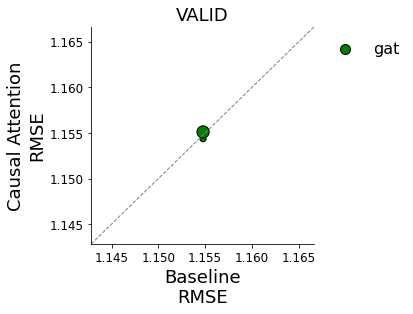

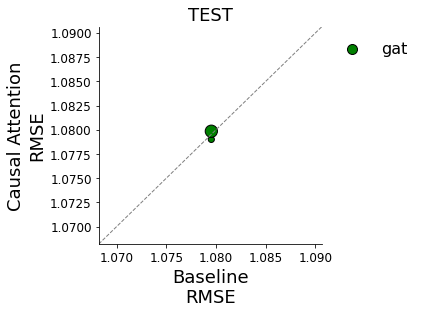

In [ ]:
from ogb.linkproppred import Evaluator

dataset_name = "ogbl-collab"
task = 'lpp'
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=500000)

evaluator = Evaluator(name = dataset_name)

eval_metric = 'hits@50'
params_dict = {'model': ['gatconv'],
               'heads': [3],
               'nl': [1],
               'hd': [10],
               'lc': [0.1],
               'ni': [1]}

save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_lpp/{}/models".format(dataset_name)

results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=1,suffix='interv.ep200',task=task)

eval_set = 'valid'
plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric)

eval_set = 'test'
plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric)


In [ ]:
from collections import Counter

train_loader,valid_loader,test_loader = load_dataloader('ogbl-ddi',batch_size=500000)


plt.hist(Counter(train_loader.data.edge_index[1].data.numpy()).values(),bins=50)
plt.show()

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.linkproppred import Evaluator

dataset_name = "ogbl-ddi"
suffix = 'interv.ep1000.self_loop.early_stop20.ratio'
task = 'lpp'
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=500000)
evaluator = Evaluator(name = dataset_name)
eval_metric = 'hits@20'

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_lpp/{}/models".format(dataset_name)
  
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/lpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

# OGB Graph Property Prediction

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molfreesolv'
# suffix = 'interv.ep2000.early_stop100.ratio'
suffix = 'interv.ep1000.early_stop20.ratio'
task = 'gpp'
eval_metric = 'kendall'
device = 0
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = KendallEvaluator() #dataset_name) # Evaluator(name = dataset_name)
# evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1,2],
               'hd': [50],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path + "K"):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')
  
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['heads'] >= 1]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-mollipo'
suffix = 'interv.ep3000.early_stop100.ratio'
eval_metric = 'kendall'
device = 0
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = KendallEvaluator() #dataset_name) # Evaluator(name = dataset_name)
# evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)

results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task='gpp')

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_df.to_csv(os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix)),sep='\t')
  
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molesol'
suffix = 'interv.ep1000.early_stop100.ratio'
eval_metric = 'kendall'
device = 0
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = KendallEvaluator() #dataset_name) # Evaluator(name = dataset_name)
# evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=0,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molbace'
suffix = 'interv.ep500.weight.early_stop20.ratio'

task = 'gpp'
eval_metric = 'rocauc'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1,2],
               'hd': [50],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path + "K"):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['heads'] >= 1]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molbace'
suffix = 'interv.ep500.weight.early_stop50.ratio'

task = 'gpp'
eval_metric = 'rocauc'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['heads'] == 3]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molhiv'
suffix = 'interv.ep1000.weight.early_stop50.ratio'
task = 'gpp'
eval_metric = 'rocauc'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [3],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=None)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molpcba'
suffix = 'interv.ep50.weight.early_stop20.ratio'
task = 'gpp'
eval_metric = 'ap'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [3],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=0,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['dim_hidden'] == 25]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=None)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.